<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Bayesian models for Machine Learning<br>Naive Bayes Classification</div>

One very common application of naive Bayes classifiers is document classification (e-mail spam filtering, sentiment analysis on social networks, technical documentation classification, customer appreciations, etc.). 

Naive Bayes classifiers for documents estimate the probability of a given document belonging to a certain class Y of documents, based on the document's contents Xi.


Suppose we want to predict the probability that sample $x$ has label $y$. This is a probability estimation problem that can be written:
$$\mathbb{P}(Y=y|X=x)$$

According to Bayes' theorem, we have:
$$\mathbb{P}(Y=y|X=x) =\frac{\mathbb{P}(X=x|Y=y)\cdot\mathbb{P}(Y=y)}{\mathbb{P}(X=x)}$$
$$\textrm{posterior} = \frac{\textrm{likelihood}\cdot\textrm{prior}}{\textrm{evidence}}$$

<div class="alert alert-success">
    
**Bayesian inference** is the problem of estimating this **posterior distribution**.<br>
In plain words, it consists in estimating the probability of label $y$, given an input $x$, using previously seen data to estimate the **likelihood** of an $x$ input associated to label $y$ and the general **prior** probability of observing label $y$.
</div>

Note that Bayesian inference applies both to classification and regression.

The goal of Bayesian inference is to estimate the label distribution for a given $x$ and use them to predict the correct label, so it is a *probabilistic approach to Machine Learning*.

The Bayesian predictor (classifier or regressor) returns the label that maximizes the posterior probability distribution.

In this (first) notebook on Bayesian modeling in ML, we will explore the method of Naive Bayes Classification.

1. [The naive Bayes assumption](#sec1)
2. [Naive Bayes classifiers in scikit-learn](#sec2)
3. [Examples](#sec3)
    1. [The "spam or ham?" example](#sec3-1)
    2. [The NIST example](#sec3-2)

# 1. <a id="sec1"></a>The naive Bayes assumption

Let's start with some illustrative data. We consider an artificial data set of 9 individuals. The first column in our data set is the sex ($S=0$ for male, 1 for female), the second is the height $H$ (in meters), the third is the weight $W$ (in kilos) and the last is the foot size $F$ (in centimeters).

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy 
scipdf = scipy.stats.norm.pdf 
fig_size=(10, 10)

# sex, height[m], weight[kg], foot size[cm]
data = np.loadtxt("sex_classif.csv")
data

array([[ 0.  ,  1.82, 82.  , 30.  ],
       [ 0.  ,  1.8 , 86.  , 28.  ],
       [ 0.  ,  1.7 , 77.  , 30.  ],
       [ 0.  ,  1.8 , 75.  , 25.  ],
       [ 1.  ,  1.52, 45.  , 15.  ],
       [ 1.  ,  1.65, 68.  , 20.  ],
       [ 1.  ,  1.68, 59.  , 18.  ],
       [ 1.  ,  1.75, 68.  , 23.  ],
       [ 1.  ,  1.58, 49.  , 19.  ]])

**Questions** :
- Using matplotlib, bokeh, seaborn or plotly, plot one relevant figure on the data

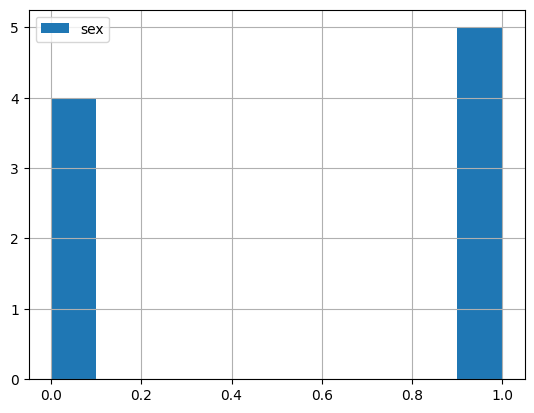

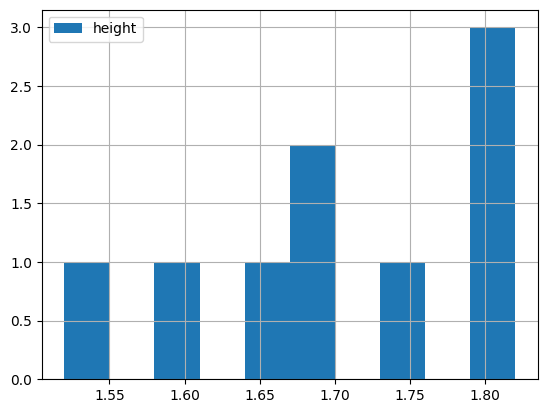

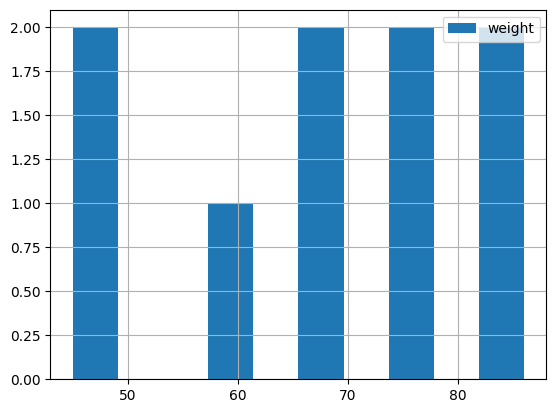

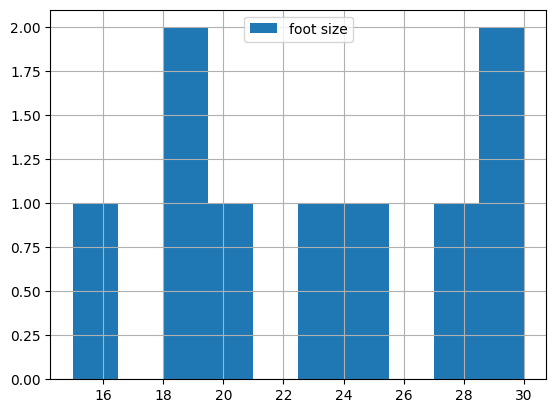

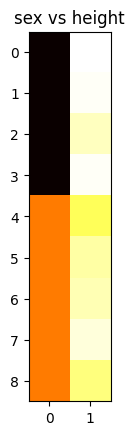

In [7]:
# your plot here
plt.figure()
plt.hist(data[:, 0], label="sex")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.hist(data[:, 1], label="height")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.hist(data[:, 2], label="weight")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.hist(data[:, 3], label="foot size")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.imshow(data[:, [0, 1]], cmap='hot', interpolation='nearest')
plt.title("sex vs height")
plt.show()


We would like to answer the question: is $(H=1.81, W=59, F=21)$ male or female?

Let's try to estimate $\mathbb{P}(S=0|H=1.81, W=59, F=21)$.

According to Bayes' theorem, the probability that a person that measures 1.81m, weights 59kgs and has a foot size of 21cm is male, is actually the likelihood of observing a person with such features among males, multiplied by the probability of observing males in the population, divided by the probability of observing an individual with these features.

That's a long sentence. Let's write that mathematically:
$$\mathbb{P}(S=0|H=1.81, W=59, F=21) = \frac{\mathbb{P}(H=1.81, W=59, F=21 | S=0)\cdot \mathbb{P}(S=0)}{\mathbb{P}(H=1.81, W=59, F=21)}$$

Let's make that more readable and more general:
$$\mathbb{P}(S|H, W, F) = \frac{\mathbb{P}(H,W,F | S)\cdot \mathbb{P}(S)}{\mathbb{P}(H,W,F)}$$

Interestingly, since our goal is only to compare the probabilities for $S=0$ and $S=1$, the denominator in the last equation won't be relevant. So we are left with two terms to estimate, given the available data:
- $\mathbb{P}(S=0)$: the prior - the probability that any individual is $S=0$, regardless of his/her physical attributes;
- $\mathbb{P}(H=1.81, W=59, F=21 | S=0)$: the likelihood of meeting somebody with the specified features, given that his/her sex is $S=0$.

The prior, in this case, is easy to estimate by comparing the frequencies of male and female individuals in the population.
\begin{gather*}
\mathbb{P}(S=0) = \frac{4}{9}\\
\mathbb{P}(S=1) = \frac{5}{9}
\end{gather*}
Technically, the estimate above is obtained by [*maximum likelihood estimation*](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

The likelihood, however, is a bit trickier. Can we directly estimate the **joint probability** of the 3 variables $(H,W,F)$?

Theoretically, we can. We can assume that among male individuals, $(H,W,F)$ are distributed according to a multivariate Normal distribution, with mean $\mu=(\mu_H, \mu_W, \mu_F)$ and covariance matrix $\Sigma$. The trick is then to estimate $\mu$ and $\Sigma$.

As a matter of fact, estimating $\mu$ and $\Sigma$ without further hypothesis would require quite a lot of data, especially because $\Sigma$ captures the **correlation** between $H$, $W$ and $F$.

$\Sigma$ is a $3\times 3$ matrix, so it involves 9 parameters to estimate, and we unfortunately only have 9 data points.

Let's rephrase this from another perspective. With some basic probabilities, we have:
\begin{align*}
\mathbb{P}(H,W,F | S) = &\mathbb{P}(H | S)\\
& \cdot \mathbb{P}(W | S, H) \\
& \cdot \mathbb{P}(F | S, H, W)
\end{align*}

Those three probabilities are univariate probabilities, much easier to estimate. However, the first one is a function of $S$ only, the second one depends on $S$ and $H$ and the third one depends on $S$, $H$ and $W$. To get an accurate estimate of the third one, we would need samples of the distribution of $F$ in enough points in the space of $(S,H,W)$ to cover it reasonably. This would require a number of data points that is exponential in the number of variables. That's what is called the **curse of dimensionality**, which makes this estimation problem difficult.

Let's make this concrete. Suppose we discretize $H$, $W$ and $F$ in 10 bins each and suppose we require 100 samples to get a correct estimate of $\mathbb{P}(F | S, H, W)$ for any given value of $(F, S, H, W)$. Then we need $100\cdot 10^3\cdot 2$ samples to correctly estimate this probability for all possible values of $(F, S, H, W)$. More generally, if we had $n$ continuous features rather than just three, we would require a number of data points that is exponential in $n$.

To circumvent this problem, we are going to make a very **naive** assumption (hence the name of the method). We are going to assume that the weight, the height and the foot size are totally independent variables, that is the probability that a person be 1.85m is the same whatever his/her weight and foot size.

Obviously, this hypothesis is very strong and clearly does not hold is most real-world cases. But we will assume it nonetheless. In this case, the likelihood estimation becomes:
\begin{align*}
\mathbb{P}(H,W,F | S) = &\mathbb{P}(H | S)\\
& \cdot \mathbb{P}(W | S) \\
& \cdot \mathbb{P}(F | S)
\end{align*}

Each of these probabilities now only depends on the label $S$ and is much easier to estimate from the data. This **conditional independence** assumption is called the **naive Bayes hypothesis**. It allow us to give a (very bad) estimate of $\mathbb{P}(X | Y)$ and hence of $\mathbb{P}(Y|X)$.

$$\mathbb{P}(S|H, W, F) = \frac{\mathbb{P}(H | S)\cdot \mathbb{P}(W | S) \cdot \mathbb{P}(F | S)\cdot \mathbb{P}(S)}{\mathbb{P}(H, W, F)}$$

Or, in our case:

$$\mathbb{P}(S=0|H=1.81, W=59, F=21) = \frac{\mathbb{P}(H=1.81 | S=0)\cdot \mathbb{P}(W=59 | S=0) \cdot \mathbb{P}(F=21 | S=0)\cdot \mathbb{P}(S=0)}{\mathbb{P}(H=1.81, W=59, F=21)}$$

The **naive Bayes classifier** is then the classifier that estimates all class probabilities and returns the one with maximum probability.

$$f(H, W, F) = \arg\max_{s} \mathbb{P}(S=s|H,W,F) = \arg\max_{s} \mathbb{P}(H|S=s)\cdot \mathbb{P}(W|S=s) \cdot \mathbb{P}(F|S=s)\cdot \mathbb{P}(S=s)$$

<div class="alert alert-warning">
    
**Exercice:**<br>
Let's implement a naive Bayes classifier on the data above, just to practice. We will assume that the $\mathbb{P}(X | S)$ distributions are Gaussians (for $X = H,W,$ or $F$). Compute the scores and probabilities for each sex, for $(H=1.81, W=59, F=21)$.<br>
Hint: use the `np.mean` and `np.std` functions to estimate distribution parameters. Use `scipy.stats.norm.pdf` to compute the Gaussian probability density function in a given input.
</div>

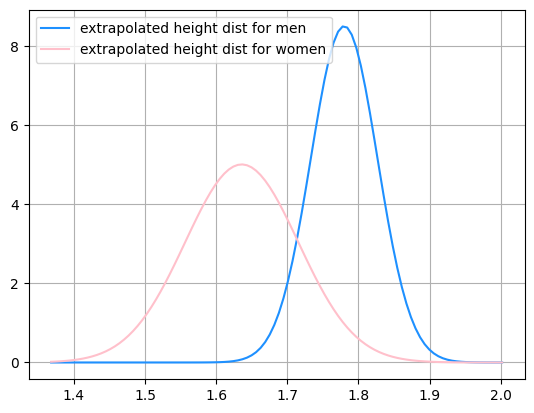

In [26]:
# P(H | S=0)
dataM = data[data[:, 0] == 0]
dataF = data[data[:, 0] == 1]

# values of height
vals_H = np.linspace(np.min(data[:, 1]*0.9), np.max(data[:, 1]*1.1), 100)
# extrapolate distribution
PDF_M_H = scipy.stats.norm(np.mean(dataM[:, 1]), np.std(dataM[:, 1]))


# values of weight
vals_W = np.linspace(np.min(data[:, 2]*0.9), np.max(data[:, 2]*1.1), 100)
# extrapolate distribution
PDF_M_W = scipy.stats.norm(np.mean(dataM[:, 2]), np.std(dataM[:, 2]))



# values of foot size
vals_F = np.linspace(np.min(data[:, 3]*0.9), np.max(data[:, 3]*1.1), 100)
# extrapolate distribution
PDF_M_F = scipy.stats.norm(np.mean(dataM[:, 3]), np.std(dataM[:, 3]))



# idem for women
PDF_F_H = scipy.stats.norm(np.mean(dataF[:, 1]), np.std(dataF[:, 1]))
PDF_F_W = scipy.stats.norm(np.mean(dataF[:, 2]), np.std(dataF[:, 2]))
PDF_F_F = scipy.stats.norm(np.mean(dataF[:, 3]), np.std(dataF[:, 3]))



# evaluate and plot results
plt.figure()
plt.plot(vals_H, PDF_M_H.pdf(vals_H), label="extrapolated height dist for men", color="dodgerblue")
plt.plot(vals_H, PDF_F_H.pdf(vals_H), label="extrapolated height dist for women", color="pink")

plt.grid()
plt.legend()
plt.show()

In [ ]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

It appears we will always multiply together values that are smaller than one. The result will quickly become very small. It is a good habit to move to log-scale.

<div class="alert alert-warning">

**Exercice:**<br>
Reuse your code above to compute log scores instead of scores.
</div>

In [ ]:
# idem, avec log scores
# au lieu de multiplier les probas, on somme les logs de probas


# evaluate and log
PDF_M_H_log = np.log(PDF_M_H.pdf(1.81))
PDF_M_W_log = np.log(PDF_M_W.pdf(59))
PDF_M_F_log = np.log(PDF_M_F.pdf(21))

# to compute formula, we need P(S=0) and P(H, W, F)
PS_M = np.sum(data[:, 0] == 0) / len(data[:, 0])
print("P(male) : ", PS_M)
PS_M_log = np.log(PS_M)
PS_F_log = np.log(1 - PS_M)

# BUT we do not need P(H, W, F) : we just want to compare the scode
score_M = PS_M_log + PDF_M_H_log + PDF_M_W_log + PDF_M_F_log
print(f"score men : {score_M}")


# avaluate and log hypothesis women
PDF_F_H_log = np.log(PDF_F_H.pdf(1.81))
PDF_F_W_log = np.log(PDF_F_W.pdf(59))
PDF_F_F_log = np.log(PDF_F_F.pdf(21))

score_F = PS_F_log + PDF_F_H_log + PDF_F_W_log + PDF_F_F_log
print(f"score women : {score_F}")

# c'est une femme

P(male) 0.4444444444444444
score men : -21.08261794758859
score women : -6.7120287353991035


In [ ]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

Conclusion: $(H=1.81,W=59,F=21)$ is most probably female.

Let's generalize.

<div class="alert alert-success">
    
    
Given $n$ features $X_i$ and classes $Y$, **naive Bayes classifiers** estimate (from data) the distributions $\mathbb{P}(Y)$ and $\mathbb{P}(X_i|Y)$. Then, using Bayes rule and the naive Bayes assumption, they predict the most probable estimated class:
\begin{align*}
\arg\max_{y} \mathbb{P}(Y=y|X=x) & = \arg\max_{y} \frac{\prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|Y=y) \mathbb{P}(Y=y)}{\mathbb{P}(X=x)}\\
& = \arg\max_{y} \prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|Y=y) \mathbb{P}(Y=y)\\
& = \arg\max_{y} \sum\limits_{i=1}^n \log\left(\mathbb{P}(X_i=x_i|Y=y)\right) + \log\left(\mathbb{P}(Y=y)\right)
\end{align*}
</div>

Note that although it is not compulsory to compute the denominator, it is quite straightforward since:
\begin{align*}
\mathbb{P}(X=x) &= \sum\limits_y \mathbb{P}(X=x|Y=y)\mathbb{P}(Y=y)\\
&= \sum\limits_y \prod\limits_{i=1}^n \mathbb{P}(X_i=x_i|Y=y) \mathbb{P}(Y=y) 
\end{align*}
So it's the sum of the numerator's values for all $y$, so it's just a matter of normalizing the scores obtained.

A really nice thing about naive Bayes classifiers is that it is an **online method**, since most univariate probability distributions can be updated incrementally, 

# <a id="sec2"></a> 2. Naive Bayes classifiers in scikit-learn

Once again, scikit-learn has a [naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) implementation. It allows three kind of distributions for the $X_i|Y$ variables: Normal (continuous), Bernouilli or Multinomial (discrete).
Let's directly use it on our toy dataset.

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

X = data[:,1:] # weight, height, footsize
y = data[:,0] # sex

gnb.fit(X,y)

xtest = np.array([[1.81,59,21]])

print("Prediction: ", gnb.predict(xtest))
print("Probas:     ", gnb.predict_proba(xtest))
print("Log probas: ",gnb.predict_log_proba(xtest))

Prediction:  [1.]
Probas:      [[5.73982396e-07 9.99999426e-01]]
Log probas:  [[-1.43706671e+01 -5.73982561e-07]]


# <a id="sec3"></a> 3. Examples

## <a id="sec3-1"></a> 3.1 The "spam or ham?" example

Let's scale up and apply naive Bayes classification on the ling-spam data. We will assume a multinomial distribution of word $i$ appearing in and email of class $y$.

In [ ]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

<div class="alert alert-warning">
    
**Exercice:**
Use scikit-learn to build a [multinomial naive Bayes classifier](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) on the data above. Estimate its generalization error.
</div>

In [ ]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

We've trained our model in the Tf-Idf data. Let's see how the model behaves on raw word counts.

<div class="alert alert-warning">

**Exercice:**
Use scikit-learn to build a [multinomial naive Bayes classifier](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) on the raw word counts data below. Estimate its generalization error.
</div>

In [ ]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')

In [ ]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

Let's identify which are the misclassified emails (and find the confusion matrix by the way).

In [ ]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_nbc = MultinomialNB()
spam_nbc.fit(Xtrain,ytrain);

In [ ]:
# Find misclassified examples
ypredict = spam_nbc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

In [ ]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

In [ ]:
# Check some misclassified mails
index = misclass_indices[1]+2000
print("Prediction:", spam_nbc.predict(spam_data.word_count[index,:]))
spam_data.print_email(index)
spam_nbc.predict_proba(spam_data.tfidf[index,:])

**Questions** :
- What are the next steps to improve the results ? To create the moderation system ?
- What questions should you ask to the tech company, before working on their data ?

## <a id="sec3-2"></a> 3.2 The NIST example

We will assume Gaussian distributions for the NIST example.

In [ ]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

#print(digits.DESCR)

#plt.gray();
#plt.matshow(digits.images[0]);
#plt.show();
#plt.matshow(digits.images[15]);
#plt.show();
#plt.matshow(digits.images[42]);
#plt.show();

from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [ ]:
Xtrain, ytrain, Xtest, ytest  = shuffle_and_split(X,y,1000)

print(Xtrain.shape)
print(ytrain.shape)
digits_nbc = GaussianNB()
digits_nbc.fit(Xtrain,ytrain)
prediction = digits_nbc.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_nbc.score(Xtest,ytest))
print("Confusion matrix:")
print(confusion_matrix(ytest, prediction))

In [ ]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_nbc = GaussianNB()
    digits_nbc.fit(Xtrain,ytrain)
    score += [digits_nbc.score(Xtest,ytest)]
    print('*',end='')
print(" done!")
    
print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

Naive Bayes classifiers reach their limits on data with high correlations between features (like images).